In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import pandas as pd

In [2]:
# Load model and data
variable_to_plot = 'Teacup Temperature'
csv_values = pd.read_csv('test.csv')
initial_values = csv_values[csv_values['Var Values'].notna()]['Var Values'].to_list()
model = pysd.read_vensim("../../System Dynamics/Jupyter/PySD-Cookbook-master/source/models/Teacup/Teacup.mdl")

In [3]:
# Bubble chart functions
def map_colors(time):
    """Map the color of the bubbles"""
    colors = {'Muito Alto': 'red', 'Alto': 'blue', 'Médio': 'yellow', 'Baixo': 'green'}
    return np.array([colors[t] for t in time])

def map_sizes(financial_impact):
    """Map the size of the bubbles"""
    return (np.array(financial_impact) / max(financial_impact)) * 3000

In [4]:
# Voxel functions
def get_values(variable, list_initial_values, model_path):
    """Get final variable values"""
    final_values = []
    for initial_value in list_initial_values: 
        res = model_path.run(initial_condition=(0, {variable: initial_value}), return_columns=[variable])   
        final_value = res[variable].iloc[-1]        
        final_values.append(final_value)
    return final_values

def map_value_to_color(value):
    """Map a normalized value to a color."""
    if value <= 0.4:
        return (1, 0, 0)  # Red
    elif value <= 0.7:
        return (1, 1, 0)  # Yellow
    else:
        return (0, 1, 0)  # Green

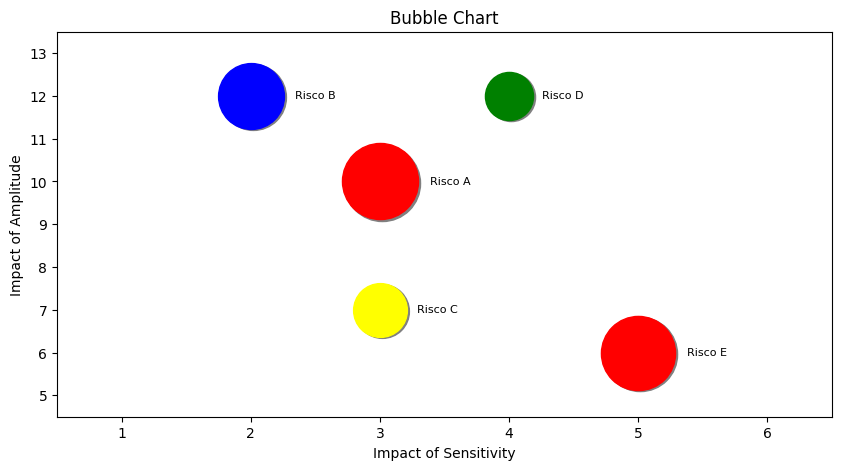

In [5]:
# Bubble chart

# Get data from DataFrame columns
risk_names = csv_values['Nome do Risco'].values
x = csv_values['Impacto de Sensibilidade'].values
y = csv_values['Impacto de Amplitude'].values
time = csv_values['Tempo'].values
financial_impact = csv_values['Impacto Financeiro'].values

# Map colors and sizes
mapped_colors = map_colors(time)
sizes = map_sizes(financial_impact)

# Plotting configuration
plt.figure(figsize=(10, 5))
plt.xlim(min(x) - 1.5, max(x) + 1.5)
plt.ylim(min(y) - 1.5, max(y) + 1.5)
plt.gca().set_facecolor('white')

# Add shadow effect
for i in range(len(x)):
    plt.scatter(x[i] + 0.015, y[i] - 0.03, s=sizes[i], c='gray', alpha=1)

for i in range(len(x)):
    plt.scatter(x[i], y[i], s=sizes[i], c=mapped_colors[i], alpha=1)
    
    # Calculate radius from size
    radius = np.sqrt(sizes[i] / np.pi)
    
    # Text placement relative to bubble edge
    text_adjustment = 0.2 + radius / 90  # Constant factor plus a term proportional to the radius
    plt.annotate(f'{risk_names[i]}', (x[i] + text_adjustment, y[i]), ha='center', va='center', fontsize=8, color='black')

plt.xlabel('Impact of Sensitivity')
plt.ylabel('Impact of Amplitude')
plt.title('Bubble Chart')

plt.show()

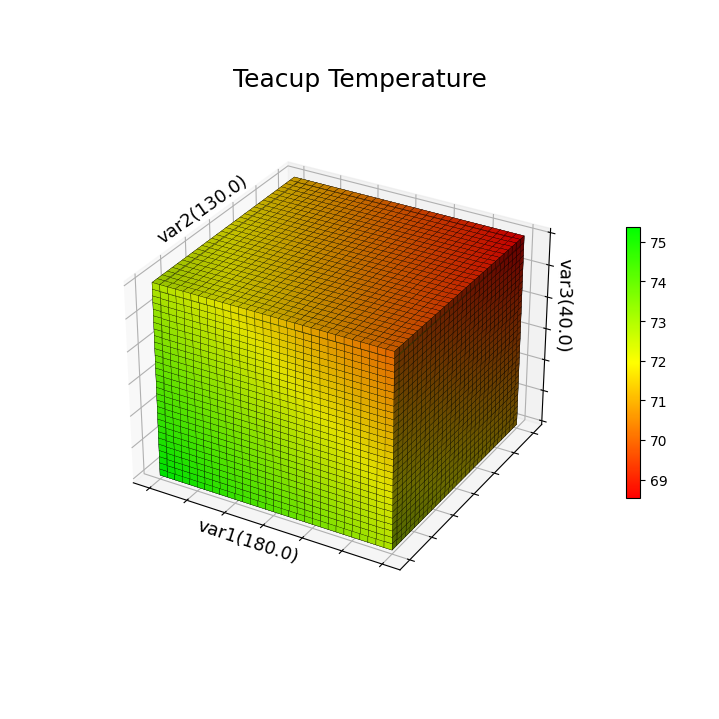

In [13]:
# Voxel

# Run model to get final values and normalizing them
final_values = get_values(variable_to_plot, initial_values, model)
min_value, max_value = min(final_values), max(final_values)

# Custom colormap
colors = []
for value in final_values:
    normalized_value = (value - min_value) / (max_value - min_value)
    colors.append(map_value_to_color(normalized_value))

cmap_name = "custom_graduated_heatmap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Plotting configuration
axes = [30, 30, 30]
data = np.ones(axes, dtype=np.float32)
x, y, z = np.meshgrid(np.linspace(0, 3, axes[0]),
                      np.linspace(0, 5, axes[1]),
                      np.linspace(0, 5, axes[2]))
heatmap_data = x + y + z
heatmap_normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
colors = custom_cmap(heatmap_normalized)

# 3D Plotting
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
voxels = ax.voxels(data, facecolors=colors, alpha=1, edgecolor='k', linewidth=0.2)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# 2D Plotting
ax2d = fig.add_axes([0, 0, 1, 1], frameon=False)
ax2d.set_xticks([])
ax2d.set_yticks([])
ax2d.text(0.5, 0.9, f'{variable_to_plot}', fontsize=18, fontweight='normal', ha='center', va='center')
ax2d.text(0.34, 0.205, f'var1({initial_values[0]})', ha="center", va="bottom", fontsize=13, rotation=-18.2)
ax2d.text(0.275, 0.66, f'var2({initial_values[1]})', ha="center", va="bottom", fontsize=13, rotation=35)
ax2d.text(0.79, 0.51, f'var3({initial_values[2]})', ha="center", va="bottom", fontsize=13, rotation=268.5)

# Colorbar
sm = cm.ScalarMappable(cmap=custom_cmap.reversed(), norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.1)

plt.show()